In [195]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
colours = ('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan')

from jit_methods import rotate
from forces.ray_tracer import make_scene

from ipywidgets import interact
import os
from importlib import import_module
import yaml

In [250]:
def prune(a):
    a.set_xlim(-1,1)
    a.set_ylim(-1,1)
    a.set_zlim(-1,1)
    a.set_xticks([])
    a.set_yticks([])
    a.set_zticks([])

xyz = np.array([[1,0,0], [0,1,0], [0,0,1]])
def axes(a, s):
    xr, yr, zr = xyz
    a.plot([0,s*xr[0]], [0, s*xr[1]], [0, s*xr[2]], c="tab:red")
    a.plot([0,s*yr[0]], [0, s*yr[1]], [0, s*yr[2]], c="tab:green")
    a.plot([0,s*zr[0]], [0, s*zr[1]], [0, s*zr[2]], c="tab:blue")

In [172]:
query = "six-sphere-rot-variables"
# query = "00-six-sphere-rot"
query = "torus mid"
choice = [d for d in os.listdir("output") if query in d]
if len(choice) == 1:
    directory = choice[0]
    print("'{}' chosen. It's contents:".format(directory))
    print(os.listdir(os.path.join("output", directory)))
elif len(choice):
    print("# " + "\n# ".join(choice))
    print("\nPlease constrain your query further, as more than one folder matches it.")
else:
    print("No folder matches your query.")

'2020-08-26-19-18-13-torus middle' chosen. It's contents:
['main.png', '0.csv', 'config.yaml', 'vx.png']


In [179]:
with open(os.path.join("output", directory, "config.yaml"), 'r') as f:
    config = yaml.safe_load(f)
if config["variables"] is not None:
    var_steps = config["variables"]["steps"]
    variables = config["variables"]["vars"]
else:
    var_steps = 1
    variables = []
    
data_all = []
details=[]
for i in range(var_steps):
    with open(os.path.join("output", directory, str(i)+".csv"), 'r') as f:
        details.append(f.readline()[2:-1])
        data_all.append(np.loadtxt(f, delimiter=","))

# Paths and orientation

<IPython.core.display.Javascript object>


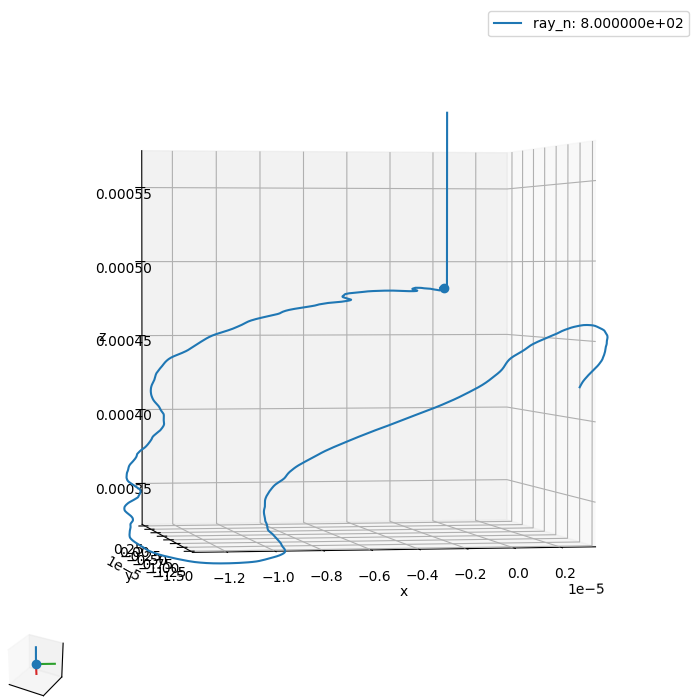

interactive(children=(IntSlider(value=0, description='val', max=2499), Output()), _dom_classes=('widget-intera…

In [253]:
figp = plt.figure(figsize=(7,7), constrained_layout=True)
axp = figp.add_subplot(111, projection='3d')
axp.set_xlabel("x")
axp.set_ylabel("y")
axp.set_zlabel("z")

points = []
rots = []
xyz = np.array([[1,0,0], [0,1,0], [0,0,1]])
for i in range(var_steps):
    axp.plot(data_all[i][:, 1], data_all[i][:, 2], data_all[i][:, 3], label=details[i])
    p, = axp.plot(*data_all[i][0,1:4].reshape((-1,1)), "o", c=colours[i])
    points.append(p)
    
    a = figp.add_axes([0.1*i, 0, 0.1, 0.1], projection='3d')
    prune(a)
    lx, = a.plot([0], [0], [0], c="tab:red")
    ly, = a.plot([0], [0], [0], c="tab:green")
    lz, = a.plot([0], [0], [0], c="tab:blue")
    a.plot([0], [0], [0], "o", c=colours[i])
    rots.append([lx, ly, lz])

frame = 0
@interact(val=(0, len(data_all[0])-1))
def update_main(val=0):
    global frame
    frame = val
    for i in range(var_steps):
        points[i].set_data([data_all[i][frame,1]], [data_all[i][frame,2]])
        points[i].set_3d_properties([data_all[i][frame,3]])
        
        xr, yr, zr = rotate(xyz, data_all[i][frame,7:11])
        rots[i][0].set_data([0,xr[0]], [0, xr[1]])
        rots[i][0].set_3d_properties([0, xr[2]])
        rots[i][1].set_data([0,yr[0]], [0, yr[1]])
        rots[i][1].set_3d_properties([0, yr[2]])
        rots[i][2].set_data([0,zr[0]], [0, zr[1]])
        rots[i][2].set_3d_properties([0, zr[2]])

axp.legend()
plt.show()

# Plot state

In [185]:
# Process variables for a given step
vi = 0
forces = []
@interact(val=(0,var_steps-1))
def set_vi(val=0):
    global vi, config
    vi = val
    with open(os.path.join("output", directory, "config.yaml"), 'r') as f:
        text = f.read()
    for i, var in enumerate(variables):
        if var_steps > 1:
            val = var["start"] + (var["end"]-var["start"])*vs/(var_steps-1)
        else:
            val = var["start"]
        text = text.replace("__{}__".format(var["name"]), "{:e}".format(val))
    config = yaml.safe_load(text)

interactive(children=(IntSlider(value=0, description='val', max=0), Output()), _dom_classes=('widget-interact'…

In [203]:
# Get the force functions
forces = []
tracer = None
for force in config["forces"]:
    m = import_module("forces." + force["type"])
    forces.append(m.factory(config, force["params"]))
    if force["type"] == "ray_tracer":
        tracer = force["params"]

Computing
Plotting


<IPython.core.display.Javascript object>


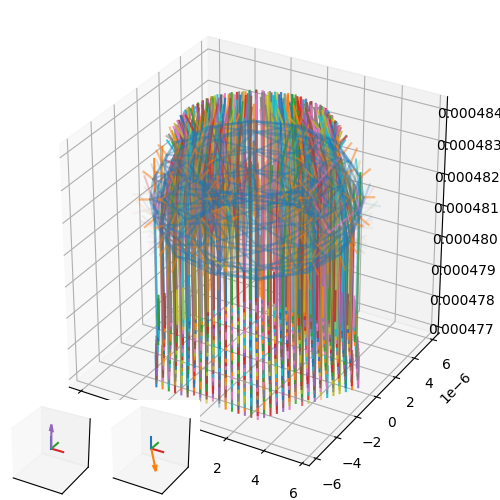

Lin. momentum: [-2.21792114e+10  4.09120715e+09  1.93618001e+13]
Ang. momentum: [ 9.85062242e+07  5.67446851e+07 -6.48253391e+08]


In [254]:
print("Computing")
print("Plotting")
s = make_scene(data_all[vi][frame][1:], tracer)
s.run(limit=tracer["limit"])
s.propagate(1e-6)

figt = plt.figure(figsize=(5,5), constrained_layout=True)
axt = figt.add_subplot(111, projection='3d')
s.plot(axt, show_weight=True)
print("Lin. momentum:", s.momentum)
print("Ang. momentum:", s.ang_momentum)
a = figt.add_axes([0, 0, 0.2, 0.2], projection='3d')
prune(a)
axes(a, .5)
a.quiver(0, 0, 0, *s.momentum, color="tab:purple", normalize=True)
a = figt.add_axes([0.2, 0, 0.2, 0.2], projection='3d')
prune(a)
axes(a, .5)
a.quiver(0, 0, 0, *s.ang_momentum, color="tab:orange", normalize=True)
plt.show()